In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from scipy import signal as scisig

In [2]:
sess = tf.InteractiveSession()

# Basic initialization

In [3]:
sample_rate = 16000 # Hz
batch_size=1
X = tf.placeholder(tf.float32, shape=[batch_size, None, 1])

nunits = 16
filter_time = 0.05 # seconds
lfilter = int(filter_time*sample_rate) # number of samples in a filter
# initialize filters...they get set to gammachirps later, though
filters = tf.Variable(tf.random_normal([nunits, lfilter, 1]))

# define op for inputs (convolve filters with signal)
conv = tf.nn.convolution(X, tf.transpose(filters,[1,2,0]), padding="SAME")

# initialize variable for dot products of each filter with [each other filter at each time offset]
filterdots = tf.Variable(tf.zeros([nunits, nunits, lfilter]))

buffer_time = .01 # seconds
lbuffer = int(buffer_time*sample_rate) # buffer length in samples

# define op for learning (which I haven't done yet), not sure the reconstruction is right
final_coeffs = tf.placeholder(tf.float32, shape=[batch_size, nunits, None])
Xhat = tf.nn.convolution(final_coeffs, tf.transpose(filters,[1,0,2]), padding="SAME", data_format="NCW")
loss = tf.reduce_mean(tf.square(X - Xhat))
learn_rate = 0.01
learner = tf.train.GradientDescentOptimizer(learn_rate)
learn_step = tf.Variable(0,name='learn_step', trainable=False)
learn_op = learner.minimize(loss, global_step=learn_step, var_list=[filters])

# Gammachirp basis

In [4]:
# dynamic compressive gammachirp
def dcGC(t,f):
    """Dynamic compressive gammachirp filter as defined by Irino,
    with parameters from Park as used in Charles, Kressner, & Rozell.
    The log term is regularized to log(t + 0.00001).
    t : time in seconds, greater than 0
    f : characteristic frequency in Hz
    One but not both arguments may be numpy arrays.
    """
    ERB = 0.1039*f + 24.7
    return t**3 * np.exp(-2*np.pi*1.14*ERB*t) * np.cos(2*np.pi*f*t + 0.979*np.log(t+0.000001))

[0.0, 0.050000000000000003, -1.178485804464082, 1.0]

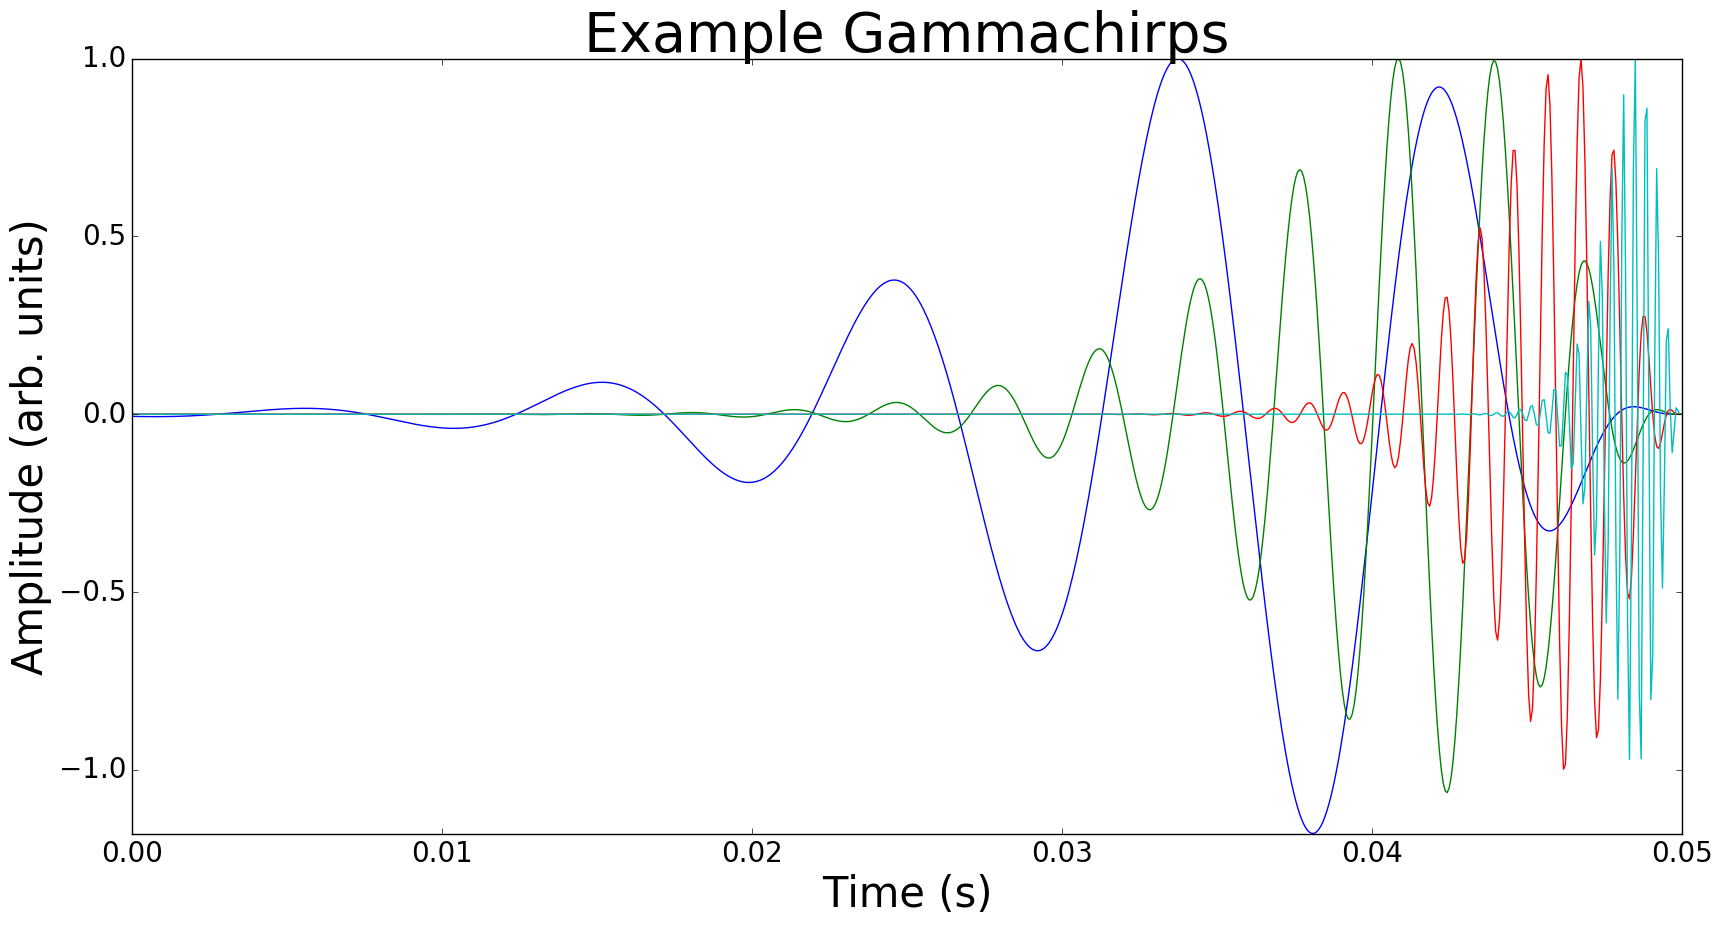

In [5]:
gammachirps = np.zeros([nunits, lfilter])
freqs = np.logspace(np.log10(100), np.log10(6000), nunits)
times = np.linspace(0,filter_time,lfilter)
plt.figure(figsize=(20,10))
for ii in range(nunits):
    gammachirps[ii] = dcGC(times[::-1], freqs[ii]) # reverse time (I think but am not sure this is the correct thing to do)
    gammachirps[ii] = gammachirps[ii]/np.max(gammachirps[ii]) # only relevant for sample plotting; gets normalized later
    if ii%4 ==0:
        plt.plot(times, gammachirps[ii])
plt.title('Example Gammachirps', fontsize=40)
plt.xlabel('Time (s)', fontsize=30)
plt.ylabel('Amplitude (arb. units)', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.axis([times[0], times[-1], np.min(gammachirps), np.max(gammachirps)])

In [6]:
sess.run(tf.global_variables_initializer())
sess.run(filters.assign(tf.constant(gammachirps.reshape([nunits,lfilter,1]), dtype=tf.float32)))
sess.run(filters.assign(tf.nn.l2_normalize(filters, dim=1)))

array([[[ -5.05971955e-04],
        [ -5.16042637e-04],
        [ -5.25421579e-04],
        ..., 
        [ -1.70490569e-06],
        [ -2.86449506e-07],
        [  0.00000000e+00]],

       [[  1.75619818e-04],
        [  1.84805249e-04],
        [  1.93682543e-04],
        ..., 
        [ -2.26972179e-06],
        [ -3.90322498e-07],
        [  0.00000000e+00]],

       [[  3.52227180e-05],
        [  3.98072989e-05],
        [  4.43322679e-05],
        ..., 
        [ -3.17705872e-06],
        [ -5.64142908e-07],
        [  0.00000000e+00]],

       ..., 
       [[ -0.00000000e+00],
        [  0.00000000e+00],
        [  0.00000000e+00],
        ..., 
        [  7.07526319e-03],
        [ -2.56134954e-04],
        [  0.00000000e+00]],

       [[  0.00000000e+00],
        [ -0.00000000e+00],
        [ -0.00000000e+00],
        ..., 
        [  7.54522998e-03],
        [  4.75309003e-04],
        [  0.00000000e+00]],

       [[ -0.00000000e+00],
        [  0.00000000e+00],
        [  

# Calculate inhibitory weights, define inhibition op

In [7]:
np_filters = np.squeeze(sess.run(filters))
padded = np.concatenate([np_filters, np.zeros_like(np_filters)], axis=1)
filterdots_np = np.zeros([nunits, nunits, lfilter])
for ii in range(lfilter):
    # the shifts go backwards, but so does the placement...so it ends up going like -H -H+1 .... -1 H
    rolled = np.roll(padded, shift=-ii, axis=1)[:,:lfilter]
    thesedots = np_filters @ rolled.T
    if ii==0:
        thesedots = thesedots - np.diag(np.diag(thesedots))
    #filterdots_np[:,ii*nunits:(ii+1)*nunits] = thesedots
    filterdots_np[:,:,-1-ii] = thesedots
sess.run(filterdots.assign(filterdots_np))


# TODO: is the inihibition op correct?
relevant_coeffs = tf.placeholder(shape=[batch_size, nunits, lfilter+lbuffer-1], dtype=tf.float32)
# inhib = tf.matmul(filterdots, tf.reshape(relevant_coeffs,[-1,1])) wrong
inhib = tf.nn.convolution(tf.transpose(relevant_coeffs,[0,2,1]), tf.transpose(filterdots, [2,1,0]), padding='VALID')

In [8]:
testinhib = sess.run(inhib, feed_dict={relevant_coeffs : np.ones([1,nunits,lfilter+lbuffer-1])})

In [9]:
testinhib.shape

(1, 160, 16)

# Inference method

In [10]:
infrate = 0.01
lam = 0.8
def infer(signal, niter):
    # pad the signal with zeros so the first buffer just codes zeros
    signal = signal.reshape([batch_size, -1, 1])
    signal = np.concatenate([np.zeros([batch_size, lfilter+lbuffer,1]), signal], axis=1)
    signal_length = signal.shape[1] # includes padding
    coeffs = np.zeros([batch_size, nunits, signal_length])
    conv_values = sess.run(conv, feed_dict={X: signal})
    for tt in range(lfilter+lbuffer, signal_length):
        buf_internal = np.zeros([batch_size, nunits, lbuffer])
        buf_excit = np.transpose(conv_values[:,tt-lbuffer+1:tt+1,:],[0,2,1])
        thresh = lam #np.array(buf_excit.mean(axis=(1,2)))
        acts = np.zeros_like(buf_internal)
        for kk in range(niter):
            # update inhibition
            np_inhib = sess.run(inhib, feed_dict = {relevant_coeffs : coeffs[:,:,tt-lfilter-lbuffer+2:tt+1]})
            # update internal variables for buffer
            delta_internal = -1*buf_internal + buf_excit - np.transpose(np_inhib, [0,2,1])
            buf_internal += infrate*delta_internal
            acts[:] = buf_internal
            acts[np.absolute(acts) < thresh] = 0 # doing this in numpy for now
            #thresh = 0.9*thresh
            #thresh[thresh < lam] = lam
            # update coefficients
            coeffs[:,:,tt-lbuffer:tt] = acts
        if tt % 50 == 0:
            print('Time step ', tt)
    return coeffs

# Load and bandpass filter a signal

In [11]:
folder = '../Data/TIMIT/'

In [12]:
files = os.listdir(folder)
file = None
for ff in files:
    if ff.endswith('.wav'):
        file = os.path.join(folder,ff)
        break
rate, signal = wavfile.read(file)
# bandpass
signal = signal/signal.std()

In [13]:
# adapted from scipy cookbook
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scisig.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scisig.lfilter(b, a, data)
    return y

lowcut = 100
highcut = 6000
signal = butter_bandpass_filter(signal, lowcut, highcut, sample_rate, order=5)

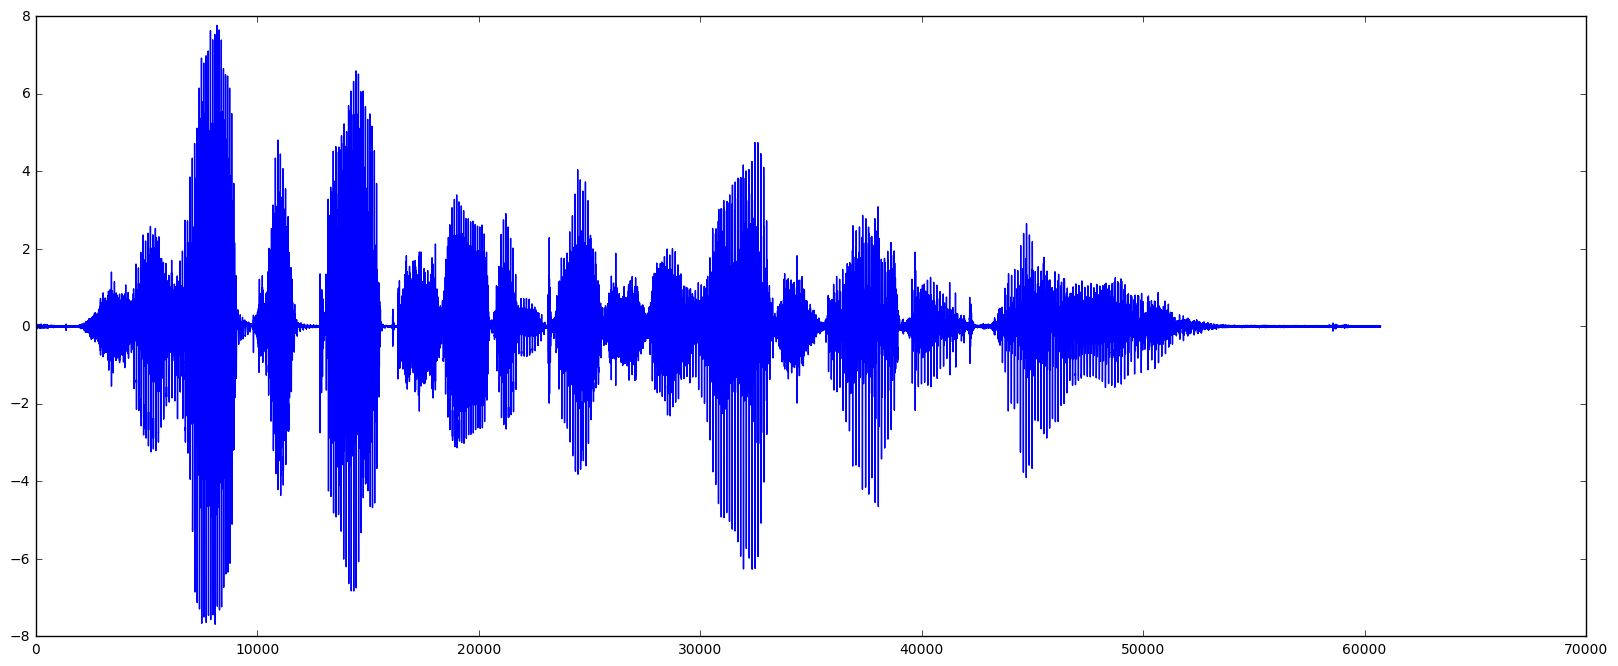

In [14]:
plt.figure(figsize=(20,8))
plt.plot(signal)

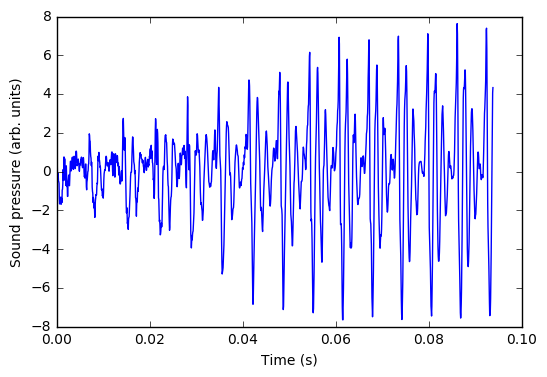

In [15]:
start = 6500
end = 8000
times = np.linspace(0, (end - start)/sample_rate,end-start)
plt.plot(times, signal[start:end])
plt.xlabel('Time (s)')
plt.ylabel('Sound pressure (arb. units)')

[0.0, 0.09375, -8, 8]

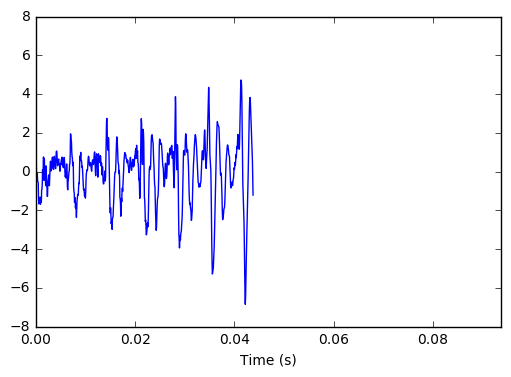

In [41]:
start = 6500
earlyend = 7200
parttimes = np.linspace(0, (earlyend - start)/sample_rate,earlyend-start)
plt.plot(parttimes, signal[start:earlyend])
plt.xlabel('Time (s)')
plt.axis([times[0], times[-1],-8,8])

# Testing

In [16]:
spikes = infer(signal[start:end], 2000)

Time step  1000
Time step  1050
Time step  1100
Time step  1150
Time step  1200
Time step  1250
Time step  1300
Time step  1350
Time step  1400
Time step  1450
Time step  1500
Time step  1550
Time step  1600
Time step  1650
Time step  1700
Time step  1750
Time step  1800
Time step  1850
Time step  1900
Time step  1950
Time step  2000
Time step  2050
Time step  2100
Time step  2150
Time step  2200
Time step  2250


/home/edodds/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in subtract
/home/edodds/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in less


Time step  2300
Time step  2350
Time step  2400
Time step  2450


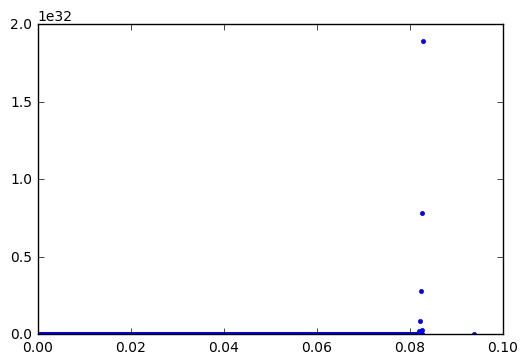

In [31]:
plt.plot(times, np.max(spikes[0,:,lfilter+lbuffer:],axis=0), 'b.')

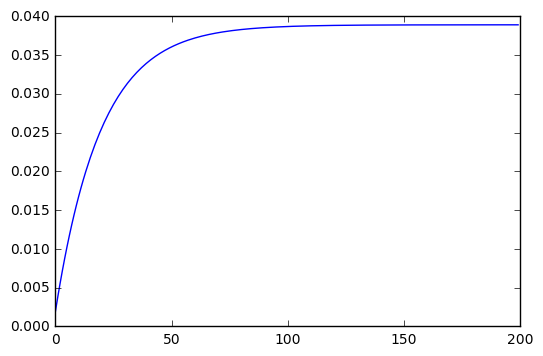

In [99]:
# this just tests the LCA on one timestep

sig = signal[7000:9000]
sig = sig.reshape([batch_size, -1, 1])
sig = np.concatenate([np.zeros([batch_size, lfilter+lbuffer,1]), sig], axis=1)
sig_length = sig.shape[1] # includes padding
coeffs = np.zeros([batch_size, nunits, sig_length])
conv_values = sess.run(conv, feed_dict={X: sig})
tt=lfilter+lbuffer
buf_internal = np.zeros([batch_size, nunits, lbuffer])
buf_excit = np.transpose(conv_values[:,tt-lbuffer+1:tt+1,:],[0,2,1])
thresh = lam #np.array(buf_excit.mean(axis=(1,2)))
acts = np.zeros_like(buf_internal)
num_iter = 200
meanu = np.zeros(num_iter)
for kk in range(num_iter):
    # update inhibition
    np_inhib = sess.run(inhib, feed_dict = {relevant_coeffs : coeffs[:,:,tt-lfilter-lbuffer+2:tt+1]})
    # update internal variables for buffer
    delta_internal = -1*buf_internal + buf_excit - np.transpose(np_inhib, [0,2,1])
    buf_internal += infrate*delta_internal
    meanu[kk] = np.mean(np.abs(buf_internal))
    acts[:] = buf_internal
    acts[np.absolute(acts) < thresh] = 0 # doing this in numpy for now
    #thresh = 0.9*thresh
    #thresh[thresh < lam] = lam
    # update coefficients
    coeffs[:,:,tt-lbuffer:tt] = acts
plt.plot(meanu)

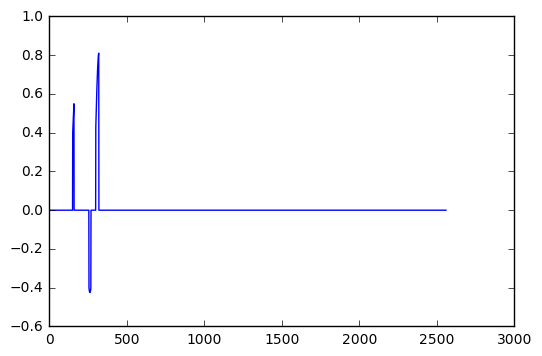

In [105]:
plt.plot(acts.flatten())

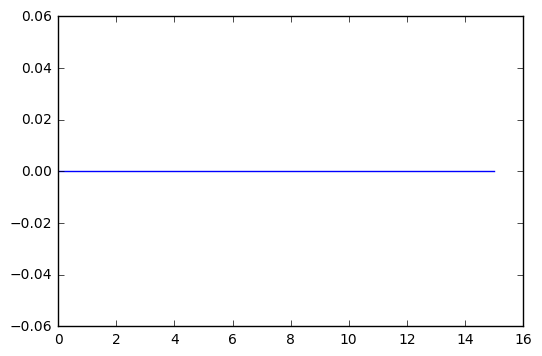

In [70]:
plt.plot(np.max(spikes[0],axis=0))

In [60]:
conv_values = sess.run(conv, feed_dict={X: signal.reshape([batch_size, -1, 1])})

In [61]:
conv_values

array([[[  4.51010885e-04,  -2.54776212e-04,   1.51676754e-03, ...,
           8.05549410e-32,   0.00000000e+00,   0.00000000e+00],
        [  3.46885878e-04,  -4.21449862e-04,   1.47546537e-03, ...,
           2.51611580e-31,   0.00000000e+00,   0.00000000e+00],
        [  2.38719484e-04,  -5.90249489e-04,   1.42551039e-03, ...,
           6.85015072e-33,   0.00000000e+00,   0.00000000e+00],
        ..., 
        [ -1.44745754e-02,   9.33888648e-03,   2.18060263e-03, ...,
          -3.72971016e-07,  -1.07283789e-07,  -7.78477656e-08],
        [ -1.43100396e-02,   8.85387510e-03,   2.25799181e-03, ...,
          -8.61408694e-07,  -2.14845855e-07,   9.63272413e-08],
        [ -1.41120497e-02,   8.33924115e-03,   2.30815448e-03, ...,
           1.93521288e-07,   1.87811125e-07,  -7.01854574e-08]]], dtype=float32)

In [62]:
buf_excit = np.transpose(conv_values[:,10*lfilter:10*lfilter+lbuffer,:],[0,2,1])

In [63]:
buf_excit

array([[[  6.23835862e-01,   7.33332455e-01,   8.40245485e-01, ...,
          -1.06586492e+00,  -1.14564228e+00,  -1.21974421e+00],
        [ -4.27601957e+00,  -4.28239870e+00,  -4.27228212e+00, ...,
           3.73897457e+00,   3.67752552e+00,   3.60273147e+00],
        [  1.65514791e+00,   1.67602932e+00,   1.69157493e+00, ...,
          -2.21508598e+00,  -2.20107651e+00,  -2.17552853e+00],
        ..., 
        [ -5.39812136e-05,  -7.20408116e-06,   4.66814781e-05, ...,
           2.66300121e-05,  -2.24607484e-05,  -3.62721221e-05],
        [  7.53615541e-06,   3.36734115e-06,  -1.08871118e-05, ...,
           8.98338203e-06,  -4.44381430e-06,  -4.71800240e-06],
        [ -7.85076040e-08,  -2.54206860e-08,   5.80152850e-08, ...,
           4.21015920e-06,  -4.12913550e-06,   1.89606578e-06]]], dtype=float32)

In [64]:
np.max(buf_excit)

4.037303

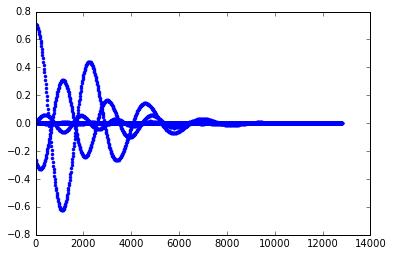

In [80]:
plt.plot(filterdots_np[0], 'b.')

# Plot spikegram

In [48]:
def plotSpikeGram( spikes, markerSize = .0001 ):
    """adapted from https://github.com/craffel/spikegram-coding/blob/master/plotSpikeGram.py"""
    nkernels = spikes.shape[0]
    indices = np.transpose(np.nonzero(spikes))
    print(indices.shape)
    scalesKernelsAndOffsets = [(spikes[idx[0],idx[1]], idx[0], idx[1]) for idx in indices]
    
    for scale, kernel, offset in scalesKernelsAndOffsets:
        # Put a dot at each spike location.  Kernels on y axis.  Dot size corresponds to scale
        plt.plot( offset/sample_rate, nkernels-kernel, 'k.', markersize=markerSize*np.abs( scale ) )
    plt.title( "Spikegram" )
    plt.xlabel( "Time (s)" )
    plt.ylabel( "Kernel" )
    plt.axis( [0.0, spikes.shape[1]/sample_rate, 0.0, nkernels-1] )
    plt.show()

(11305, 2)


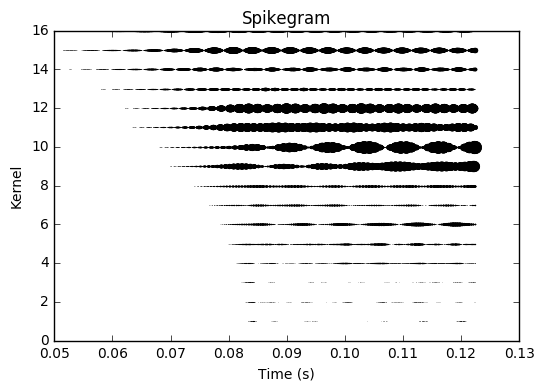

In [33]:
plotSpikeGram(spikes[0], 1)

(229, 2)


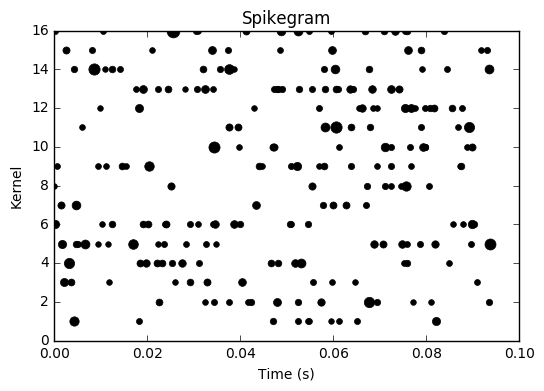

In [38]:
fake = np.random.laplace(0,1,[nunits, end-start])
fake[fake < 4] = 0
plotSpikeGram(fake,2)

(95, 2)


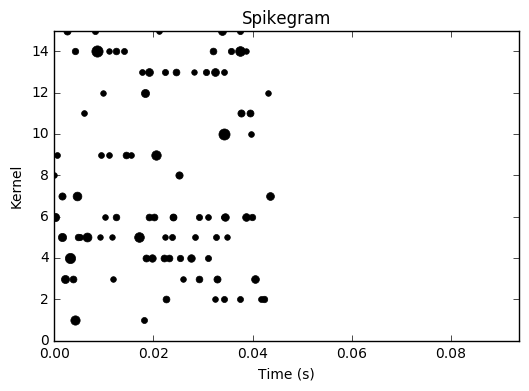

In [49]:
partfake = fake.copy()
partfake[:,700:] = 0
plotSpikeGram(partfake,2)